In [1]:
import torch 
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import pandas as pd

In [2]:
import torch
import torchinfo
import torchvision
import torch.nn.functional as F

from torch import nn
from torchvision import transforms
from torch.cuda.amp import autocast,GradScaler
from torchvision.models.resnet import BasicBlock
from tensorboardX import SummaryWriter

In [3]:
import os
import cv2
import PIL
import time
import numpy as np
import pandas as pd
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
from typing import Tuple,List,Dict
from xml.etree import cElementTree as etree

In [4]:
class yolov1_resnet(nn.Module):
    
    def __init__(self, layer:int):
        super(yolov1_resnet,self).__init__()
        if layer == 18:
            self.backbone = torchvision.models.resnet18(pretrained=True)
        elif layer == 34:
            self.backbone = torchvision.models.resnet34(pretrained=True)  
        elif layer == 50:
            self.backbone = torchvision.models.resnet50(pretrained=True)
        else:
            raise NotImplementedError
            
        self.backbone.fc = nn.Identity()
        
        # as paper suggested, deeper conv layer
        in_ch = 512 if layer != 50 else 2048
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch,1024,3,stride=1,padding=1,bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024,1024,3,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024,1024,3,stride=1,padding=1,bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024,1024,3,stride=1,padding=1,bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
        )
        
#         self.conv = self.backbone._make_layer(BasicBlock, 1024, 2, stride=2)
                
        # too much parameters, over one fourth billion
#         self.classifier = nn.Sequential(
#             nn.Linear(7*7*512,1024),
#             nn.Dropout(p=.5),
#             nn.LeakyReLU(0.1),
#             nn.Linear(1024,7*7*30),
#         )

        self.conv_out = nn.Sequential(
            nn.Conv2d(1024,11,(1,1),stride=1)
        )

        
    def forward(self,x):
        tmp = self.backbone.conv1(x)
        tmp = self.backbone.bn1(tmp)
        tmp = self.backbone.relu(tmp)
        tmp = self.backbone.maxpool(tmp)
        tmp = self.backbone.layer1(tmp)
        tmp = self.backbone.layer2(tmp)
        tmp = self.backbone.layer3(tmp)
        tmp = self.backbone.layer4(tmp)
        
        tmp = self.conv(tmp)
        tmp = self.conv_out(tmp)
        
#         tmp = torch.flatten(tmp,start_dim=1)
#         tmp = self.classifier(tmp)
#         tmp = tmp.reshape(-1,30,7,7)#.contiguous()
        
        return tmp



In [5]:
yolov1_resnet(18)(torch.randn(1,3,448,448)).shape

torch.Size([1, 11, 7, 7])

In [6]:
torch.randn((2,2)).cuda()

tensor([[ 0.8608,  0.9870],
        [-0.1757,  0.9297]], device='cuda:0')

In [6]:
yolov1_resnet(34)(torch.randn(1,3,448,448)).shape

torch.Size([1, 11, 7, 7])

In [5]:
yolov1_resnet(50)(torch.randn(1,3,448,448)).shape

torch.Size([1, 11, 7, 7])

In [6]:
from typing import Tuple

In [7]:
def generate_grid_train(grid_size: Tuple[int, int]) -> torch.Tensor:
    # recover x,y coord since we use x,y offset
    grid_x, grid_y = grid_size
    y_offset, x_offset = torch.meshgrid(torch.arange(grid_x),torch.arange(grid_y))    
    
    grid_tmp = torch.cat([x_offset.unsqueeze(0),y_offset.unsqueeze(0)],dim=0) # 2, 7, 7

    grid_tmp = grid_tmp.unsqueeze(0)/grid_size[0] # 1, 2, 7 ,7 # to relative
    
    return grid_tmp

In [8]:
def xywh_to_xyxy(coord: torch.Tensor) -> torch.Tensor:
    # convert xywh to xyxy
    b, _, sx, sy = coord.shape
    d = 'cuda:0' if coord.is_cuda else 'cpu'
    grid_for_train = generate_grid_train((sx,sy)).repeat(b,1,1,1).to(d) 
    xy = coord[:,0:2,:,:]+grid_for_train # B, 2, 7, 7
    wh = coord[:,2:4,:,:] # B, 2, 7, 7 

    return torch.cat([xy-wh/2,xy+wh/2],dim=1) # B, 4, 7, 7

In [9]:
def IOU(cbox1: torch.Tensor, cbox2: torch.Tensor) -> torch.Tensor:
    """
    input: x_offset y_offset wh format
    output: iou for each batch and grid cell
    """
        
    # coord_conversion
#     cbox1[:,2:4,:,:] = cbox1[:,2:4,:,:].pow(2)
    box1 = xywh_to_xyxy(cbox1) # B, 4, 7, 7
    box2 = xywh_to_xyxy(cbox2)
    
    # find intersection
    x1 = torch.max(box1[:,0:1,:,:],box2[:,0:1,:,:])
    y1 = torch.max(box1[:,1:2,:,:],box2[:,1:2,:,:])
    x2 = torch.min(box1[:,2:3,:,:],box2[:,2:3,:,:])
    y2 = torch.min(box1[:,3:4,:,:],box2[:,3:4,:,:])
    
    intersection = (x2-x1).clamp(min=0) * (y2-y1).clamp(min=0) # N, 1, 7, 7
    
    total_area = abs(cbox1[:,2:3,:,:] * cbox1[:,3:4,:,:]) + cbox2[:,2:3,:,:]*cbox2[:,3:4,:,:] - intersection # N, 1, 7, 7

    intersection[intersection.gt(0)] = intersection[intersection.gt(0)] / total_area[intersection.gt(0)]
    
#     intersection.clamp_(min = 0, max = 1) #TODO: check if clamp and abs prediction area necessary
    
    return intersection

In [10]:
def RMSE(cbox1: torch.Tensor, cbox2: torch.Tensor) -> torch.Tensor:
    with torch.no_grad():
        cbox1[:,2:4,:,:] = cbox1[:,2:4,:,:]
        cbox2[:,2:4,:,:] = cbox2[:,2:4,:,:].sqrt()
    return F.mse_loss(cbox1,cbox2, reduction='none')

In [11]:
IMAGE_SIZE=448

In [12]:
NUM_BOXES = 2

In [13]:
torch.backends.cudnn.benchmark=True

In [14]:
DEVICE = 'cuda:0'
NUM_BOXES = 2
NUM_CLASSES = 1
LR = 1e-4
DECAY = 5e-4

In [15]:
from typing import List

In [16]:
class YoloLoss(nn.Module):
    
    def __init__(self, lambda_coord = 5, lambda_noobject = 0.5):
        super(YoloLoss,self).__init__()
        
        self.grid_size = IMAGE_SIZE//64
        self.lambda_coord = lambda_coord
        self.lambda_noobject = lambda_noobject
        self.epsilon = 1e-5
        
    def positive_box(self, prediction: torch.Tensor, groundtruth: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        with torch.no_grad():
            ious = [IOU(prediction[:,(1+5*b):(5+5*b),:,:], groundtruth[:,1:5,:,:]) for b in range(NUM_BOXES)]
#             rmse = [RMSE(prediction[:,(1+5*b):(5+5*b),:,:], groundtruth[:,1:5,:,:]) for b in range(NUM_BOXES)]
        ious = torch.cat(ious, dim=1) # N, 2, 7, 7
#         rmse = torch.cat(rmse, dim=1)
        
        max_iou, best_box = ious.max(dim=1,keepdim=True) # N,1,7,7
        best_box = torch.stack([best_box.eq(b).int() for b in range(NUM_BOXES)], 1) # N, 2, 1, 7, 7
        max_iou = torch.stack([max_iou for b in range(NUM_BOXES)], 1) # N, 2, 1, 7, 7
        
#         min_rmse, alt_box = rmse.min(dim=1,keepdim=True)
#         alt_box = torch.stack([alt_box.eq(b).int() for b in range(NUM_BOXES)], 1) # N, 2, 1, 7, 7
#         min_rmse = torch.stack([min_rmse for b in range(NUM_BOXES)], 1) # N, 2, 1, 7, 7
        
#         best_box[max_iou.le(0).logical_and(min_rmse.lt(20))] = alt_box[max_iou.le(0).logical_and(min_rmse.lt(20))]
        
        return max_iou, best_box
    
    def build_target(self, groundtruth: List[tuple]) -> torch.Tensor:        
        label = torch.zeros((5+NUM_CLASSES, self.grid_size, self.grid_size))
                
        for g in groundtruth:
            cx, cy, w, h, c = g
            c = int(c)
            x = (cx % (1/self.grid_size)) # left offset
            y = (cy % (1/self.grid_size)) # top offset
        
            x_ind = int(cx*self.grid_size)
            y_ind = int(cy*self.grid_size)
            label[0,y_ind,x_ind] = 1
            label[1:5,y_ind,x_ind] = torch.Tensor([x,y,w,h])
            label[5+c,y_ind,x_ind] = 1
        
        return label
        
    def forward(self, prediction: torch.Tensor, groundtruth: list) -> torch.Tensor:
        b, _, grid_y, grid_x = prediction.shape
        groundtruth = torch.stack([self.build_target(g) for g in groundtruth],0).float().to(DEVICE)
        
        # iou indicator
        ious, best_box = self.positive_box(prediction, groundtruth) # N, 2, 1, 7, 7
        
        # predictions
        box_pred = prediction[:,:5*NUM_BOXES,:,:].reshape(b, NUM_BOXES, 5, grid_y, grid_x) # N, 2, 5, 7, 7
        xy_pred = box_pred[:,:,1:3,:,:]
#         wh_pred = box_pred[:,:,3:5,:,:]
        wh_pred = box_pred[:,:,3:5,:,:].sign() * (box_pred[:,:,3:5,:,:].abs()+self.epsilon).sqrt() # sqrt the value then plus sign back
        
        cls_pred = prediction[:,NUM_BOXES*5:,:,:] # N, 20, 7, 7
    
        # groundtruth
        box_truth = groundtruth[:,1:5,:,:].unsqueeze(1).tile(1,NUM_BOXES,1,1,1)
        box_truth[:,:,2:4,:,:] = box_truth[:,:,2:4,:,:].sqrt() # N, 2, 4, 7, 7
    
        # obj indicator
        obj_here = groundtruth[:,0:1,:,:] # N,1,7,7
        box_here = obj_here.unsqueeze(1) # N, 1, 1, 7, 7
        positive = box_here * best_box
        
        # class loss objecness loss and xywh loss                
        # indicator has to be inside the loss function
        cls_loss = F.mse_loss(obj_here * cls_pred, groundtruth[:,5:,:,:],reduction="sum")
        xy_loss = F.mse_loss(positive * xy_pred, positive * box_truth[:,:,0:2,:,:],reduction="sum")
        wh_loss = F.mse_loss(positive * wh_pred, positive * box_truth[:,:,2:4,:,:],reduction="sum")
        obj_loss = F.mse_loss(positive * box_pred[:,:,0:1,:,:], positive * ious,reduction="sum")
        noobj_loss = F.mse_loss((1 - positive) * box_pred[:,:,0:1,:,:], ious*0, reduction="sum")    
        
        total_loss = cls_loss + self.lambda_noobject * noobj_loss + obj_loss + self.lambda_coord * (xy_loss+wh_loss)

        return total_loss

In [17]:
def collate_fn(batch):
    img_list = []
    label_list = []
    
    for a,b in batch:
        img_list.append(a)
        label_list.append(b)
        
    return torch.stack(img_list,0), label_list

In [18]:
class AirDataset(torch.utils.data.Dataset):
    def __init__(self,csv_file,img_dir,label_dir,S=7,B=2,C=1,transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform = transform
        self.S = S
        self.B = B
        self.C = C
    
    def __len__(self):
        return len(self.annotations)


    def get_img(self,index):
        img_path = os.path.join(self.img_dir, self.annotations.iloc[index, 1])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h,w,_ = img.shape
        return img,h,w

    def process_label(self,index,img_h,img_w):
        label_path = os.path.join(self.label_dir, self.annotations.iloc[index, 0])
        boxes = []
        with open(label_path) as f:
            for label in f.readlines()[1:]:
                x1, y1, x2, y2 = [
                    float(x) if float(x) != int(float(x)) else int(x)
                    for x in label.replace("\n", "").split()
                ]
                
                w = (x2-x1)/img_w
                h = (y2-y1)/img_h
                cx = ((x1+x2)/2)/img_w
                cy = ((y1+y2)/2)/img_h
                boxes.append([cx,cy,w,h,0])
        return boxes
        


    
        
    
    def __getitem__(self, index):
        img,h,w = self.get_img(index)
        boxes = self.process_label(index,h,w)
        if self.transform:
            transformed_data = self.transform(image=img,bboxes=boxes)
            img = transformed_data['image']
            boxes = transformed_data['bboxes']
        return img,boxes   

In [19]:
path = "Images"
annot = "Airplanes_Annotations"

In [20]:
MODEL_BACKBONE = 'resnet50'

if MODEL_BACKBONE == 'yolov1':
    BATCH_SIZE = 64
    ACC_ITER = 1
elif MODEL_BACKBONE == 'resnet18':
    BATCH_SIZE = 32
    ACC_ITER = 2
elif MODEL_BACKBONE == 'resnet34':
    BATCH_SIZE = 16
    ACC_ITER = 4
elif MODEL_BACKBONE == 'resnet50':
    BATCH_SIZE = 8
    ACC_ITER = 8
    
IMAGE_SIZE = 448
DEVICE = 'cuda:0'
NUM_BOXES = 2
NUM_CLASSES = 1
LR = 1e-4
DECAY = 5e-4

In [21]:
preprocess_train = A.Compose([
    A.Resize(IMAGE_SIZE,IMAGE_SIZE),
    A.ColorJitter(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5, rotate_limit= 0),
    A.Normalize(mean=(0,0,0),std=(1,1,1)),
    ToTensorV2(),
],bbox_params=A.BboxParams(format='yolo',min_area=1024,min_visibility=0.3))

In [22]:
preprocess_val = A.Compose([
    A.Resize(IMAGE_SIZE,IMAGE_SIZE),
    A.Normalize(mean=(0,0,0),std=(1,1,1)),
    ToTensorV2(),
],bbox_params=A.BboxParams(format='yolo',min_area=1024,min_visibility=0.3))

In [23]:
trainset = AirDataset(csv_file="AirAnnotations1.csv",img_dir=path,label_dir=annot, transform=preprocess_train)
testset = AirDataset(csv_file="AirAnnotations2.csv",img_dir=path,label_dir=annot,transform=preprocess_val)

In [24]:
testset = AirDataset(csv_file="AirAnnotations2.csv",img_dir=path,label_dir=annot,transform=preprocess_val)

In [25]:
trainloader = torch.utils.data.DataLoader(trainset,batch_size=BATCH_SIZE,shuffle=True,collate_fn=collate_fn)
testloader = torch.utils.data.DataLoader(testset,batch_size=BATCH_SIZE,shuffle=True,collate_fn=collate_fn)

In [26]:
model = yolov1_resnet(50).to(DEVICE)

In [27]:
DEVICE

'cuda:0'

In [27]:
criterion = YoloLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=LR,weight_decay=DECAY)

In [28]:
writer = SummaryWriter()

In [30]:
def train(e):
    model.train()
    optimizer.zero_grad(set_to_none=True)
    for i, data in enumerate(tqdm(trainloader)):

        img, label = data
        
        img= img.to(DEVICE) 

        output = model(img)
        loss = criterion(output,label)
        loss = loss/ACC_ITER
        
        loss.backward()
        
        if i % ACC_ITER == 0:
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)
        
        assert not np.isnan(loss.item()), 'loss died'
        
        writer.add_scalar(f'training loss', loss.item(), i+e*len(trainloader),
                         summary_description=f'{MODEL_BACKBONE}/{LR}/final')

    
    if (e+1) % 10 == 0:
        torch.save(model.state_dict(),f'yolov1.{MODEL_BACKBONE}.{e+1}.pth')
    

In [31]:
def validate(e):
    model.eval()
    val_loss = 0
    print('validating......')
    with torch.no_grad():
        for i, data in enumerate(tqdm(testloader)):

            img, label = data

            img= img.to(DEVICE) 
            label = label.to(DEVICE) 

            output = model(img)
            loss = criterion(output,label)
            val_loss += loss.item()

            assert not np.isnan(val_loss), 'loss died'

    writer.add_scalar(f'validation loss', val_loss/len(testset), e,
                      summary_description=f'{MODEL_BACKBONE}/{LR}/plateau')
    return val_loss/len(testset)

In [32]:
epoches = 150
for epoch in range(0,epoches):
    train(epoch)

  0%|          | 0/44 [00:00<?, ?it/s]/home/labuser/miniconda3/lib/python3.9/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755849709/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
 66%|██████▌   | 29/44 [00:07<00:03,  4.08it/s]


KeyboardInterrupt: 

In [32]:
epoches = 120
for epoch in range(0,epoches):
    train(epoch)

  0%|          | 0/44 [00:00<?, ?it/s]/home/labuser/miniconda3/lib/python3.9/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755849709/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|██████████| 44/44 [00:10<00:00,  4.08it/s]


In [29]:
model.load_state_dict(torch.load(f'yolov1.{MODEL_BACKBONE}.100.pth'))

<All keys matched successfully>

In [30]:
def generate_grid(grid_size: Tuple[int]) -> torch.Tensor:
    grid_x, grid_y = grid_size
    y_offset, x_offset = torch.meshgrid(torch.arange(grid_x),torch.arange(grid_y))
    
    return x_offset, y_offset

In [31]:
def yolov1_decode(featuremap: torch.Tensor, model_image_size: Tuple[int, int], num_classes: int, num_anchors: int) -> torch.Tensor:
    
    batch_size, channel_size, fm_h, fm_w = featuremap.shape
    input_h, input_w = model_image_size
    stride_x, stride_y = input_w/fm_w, input_h/fm_h
    num_bbox = int((channel_size - num_classes)/5)
    
    grid_x, grid_y = generate_grid((fm_w,fm_h))

    bbox_info = []
    for b in range(num_bbox):
        # batch_size, 1, grid_size x grid_size
        cx = (featuremap[:,(1+5*b):(2+5*b),:,:]*input_w+grid_x*stride_x).reshape(batch_size,1,-1) 
        cy = (featuremap[:,(2+5*b):(3+5*b),:,:]*input_h+grid_y*stride_y).reshape(batch_size,1,-1)
        w = (featuremap[:,(3+5*b):(4+5*b),:,:]*input_w).reshape(batch_size,1,-1) 
        h = (featuremap[:,(4+5*b):(5+5*b),:,:]*input_h).reshape(batch_size,1,-1)
        conf = featuremap[:,0+5*b,:,:].reshape(batch_size,1,-1)
        prob = featuremap[:,5*num_bbox:,:,:].reshape(batch_size,num_classes,-1)
        x = cx - w/2
        y = cy - h/2
                
        bbox_info.append(torch.cat([x,y,w,h,conf,prob],1))
        
    result = torch.cat(bbox_info,-1).transpose(1,2)

    return result

In [32]:
def draw_pred(img:np.ndarray, bboxes: torch.Tensor, class_show:bool):
    """draw predicted bbox"""
    
    for b in bboxes:
        x, y, w, h, c = b[:5]
        x, y, w, h = int(x), int(y), int(w), int(h)
        prob, cls_index = b[5:].max(0)
        if prob > conf_thres:
            cv2.rectangle(img,(x,y),(x+w,y+h),(0,0,255),2)

In [33]:
result = {}
conf_thres = 0.3
nms_thres = 0.5

In [34]:
def draw_label(img:np.ndarray, label: torch.Tensor):
    """draw detection label"""
    
#     label[:5,:].reshape(5,-1).transpose(1,0)
    for i, (x,y,w,h,c) in enumerate(label):
#         grid_x, grid_y = i%7, i//7
#         cx, cy = grid_x*64+int(x*IMAGE_SIZE), grid_y*64+int(y*IMAGE_SIZE)
#         w, h = int(w*IMAGE_SIZE) , int(h*IMAGE_SIZE)
#         x, y = int(cx-w/2), int(cy-h/2)
        x,y,w,h = x*IMAGE_SIZE, y*IMAGE_SIZE, w*IMAGE_SIZE, h*IMAGE_SIZE
        x1, y1, x2, y2 = int(x-w/2), int(y-h/2), int(x+w/2), int(y+h/2),
        cv2.rectangle(img,(x1,y1),(x2,y2),(0,255,0),2)

In [35]:
def model_predict(img: torch.Tensor) -> torch.Tensor:
    
    with torch.no_grad():
        img = img.unsqueeze(0).to(DEVICE) if img.dim() == 3 else img.to(DEVICE)
        model.eval()
        pred = model(img)

        pred = pred.detach().cpu()
        img = img.detach().cpu()
    
    return pred

In [36]:
def nms(bbox: torch.Tensor, score: torch.Tensor, nms_thres: float, conf_thres: float) -> list:
    c_sort, sort_index = score.sort(descending=True)
    tmp_bbox = bbox[sort_index]

    best_index = []
    remove_index = []
    for i, (b,c) in enumerate(zip(tmp_bbox,c_sort)):
        if i==len(tmp_bbox)-1: break
        if i in remove_index: continue
        if conf_thres > c: continue
        x,y,w,h = b
        if w > 0 and h > 0 and c > 0 and 1 > c:
            best_index.append(sort_index[i].item())
            remove_index.append(i)
            b = torchvision.ops.box_convert(b.unsqueeze(0),'xywh','xyxy')
            other_b = torchvision.ops.box_convert(tmp_bbox[(i+1):],'xywh','xyxy')
            iou = torchvision.ops.box_iou(b,other_b)[0]
            over_index = iou.gt(nms_thres).nonzero().flatten().add(i+1).tolist()
            remove_index.extend(over_index)

    return best_index

In [37]:
def tensor2np_uint8(img: torch.Tensor) -> np.ndarray:
    assert img.dim() == 3, 'please provide tensor in shape C,H,W.'
    return (img.permute(1,2,0).numpy().copy()*255).astype(np.uint8)

In [38]:
conf_thres = 0.3
nms_thres = 0.5

In [50]:
testimg, labels = testset[5]
testimgpred = model_predict(testimg)

In [44]:
len(testset)

16

In [49]:
testset[5]

(tensor([[[0.3098, 0.3098, 0.3059,  ..., 0.3451, 0.3412, 0.3412],
          [0.3098, 0.3059, 0.3059,  ..., 0.3451, 0.3451, 0.3412],
          [0.3059, 0.3059, 0.3020,  ..., 0.3490, 0.3451, 0.3451],
          ...,
          [0.3608, 0.3647, 0.3686,  ..., 0.2471, 0.2353, 0.2235],
          [0.4706, 0.4588, 0.4392,  ..., 0.2549, 0.2392, 0.2314],
          [0.5412, 0.5176, 0.4824,  ..., 0.2588, 0.2471, 0.2392]],
 
         [[0.3255, 0.3216, 0.3216,  ..., 0.3882, 0.3843, 0.3843],
          [0.3255, 0.3216, 0.3216,  ..., 0.3882, 0.3843, 0.3843],
          [0.3216, 0.3216, 0.3176,  ..., 0.3922, 0.3882, 0.3882],
          ...,
          [0.3647, 0.3686, 0.3725,  ..., 0.2863, 0.2706, 0.2588],
          [0.4745, 0.4627, 0.4431,  ..., 0.2902, 0.2745, 0.2706],
          [0.5451, 0.5216, 0.4863,  ..., 0.2902, 0.2824, 0.2745]],
 
         [[0.3294, 0.3255, 0.3255,  ..., 0.3961, 0.3922, 0.3922],
          [0.3294, 0.3255, 0.3255,  ..., 0.3961, 0.3961, 0.3922],
          [0.3255, 0.3216, 0.3216,  ...,

In [51]:
bbox_result = yolov1_decode(testimgpred, (IMAGE_SIZE,IMAGE_SIZE), 1, 1)

In [52]:
bbox_result

tensor([[[ 5.8504e+00,  2.6427e+01,  5.1462e+01,  5.7931e+00, -1.6201e-02,
           8.9308e-01],
         [ 8.4794e+01,  1.0140e+01,  8.1063e+01, -1.1226e+00, -3.0764e-04,
           8.3231e-01],
         [ 1.4771e+02,  5.8964e+00,  6.8422e+01,  3.3803e+01,  1.8678e-03,
           8.8997e-01],
         [ 2.1438e+02,  1.4966e+01,  8.9920e+01,  3.1562e+01, -9.8225e-03,
           8.7343e-01],
         [ 2.7386e+02,  9.9789e+00,  8.6017e+01,  3.1548e+01, -4.7375e-03,
           8.9581e-01],
         [ 3.4564e+02,  1.7656e+00,  6.1536e+01,  3.1700e+01, -1.5681e-02,
           8.8710e-01],
         [ 3.8322e+02,  8.8466e+00,  7.0242e+01,  3.1001e+01,  1.6660e-03,
           9.1428e-01],
         [-3.1575e+01,  5.8731e+01,  8.9132e+01,  4.8052e+01, -5.6645e-03,
           8.6344e-01],
         [ 2.3862e+01,  4.1220e+01,  1.2043e+02,  6.3325e+01,  2.2383e-02,
           7.7530e-01],
         [ 8.5973e+01,  4.9417e+01,  1.4227e+02,  6.1486e+01, -2.7694e-04,
           8.2080e-01],
         [

In [39]:
def lots_of_prediction_and_lots_of_model(label_index: list, model_list: list):
    
    num_col = 2+len(model_list)
    
    for i in label_index:
        testimg, labels = testset[i]

        plt.figure(figsize=(30,30))

        plt.subplot(1,num_col,1)
        plt.title('original')
        copy_img = tensor2np_uint8(testimg)
        plt.imshow(copy_img)

        plt.subplot(1,num_col,2)
        plt.title('ground truth')
        copy_img = tensor2np_uint8(testimg)
        draw_label(copy_img, labels) 
        plt.imshow(copy_img)

        for mi, m in enumerate(model_list):
            model.load_state_dict(torch.load(m))

            testimgpred = model_predict(testimg)
            bbox_result = yolov1_decode(testimgpred, (IMAGE_SIZE,IMAGE_SIZE), 1, 1)[0]  # 1,98,25 -> 98,25
            bbox_result[:,5:] = bbox_result[:,4:5]*bbox_result[:,5:]
            cls_index = bbox_result[:,5:].argmax(1)
            
            detection_result = []
            for c in range(1):
                if cls_index.eq(c).any(): 
                    this_class_detection = bbox_result[cls_index.eq(c)]
                    best_index = nms(this_class_detection[:,:4], this_class_detection[:,5+c],
                                     nms_thres, conf_thres)
                    detection_result.append(this_class_detection[best_index])
            detection_result = torch.cat(detection_result,0)
            
            plt.subplot(1,num_col,mi+3)
            plt.title(m)
            copy_img = tensor2np_uint8(testimg)
            draw_pred(copy_img, detection_result, class_show=True)
            plt.imshow(copy_img)

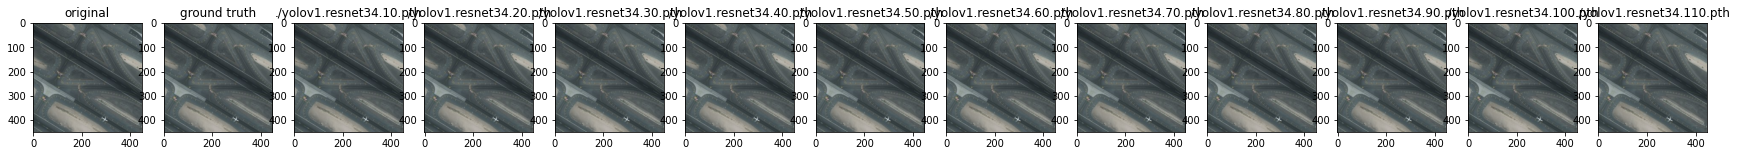

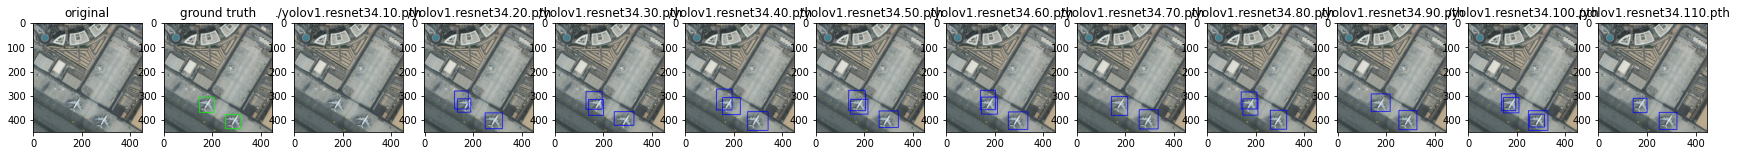

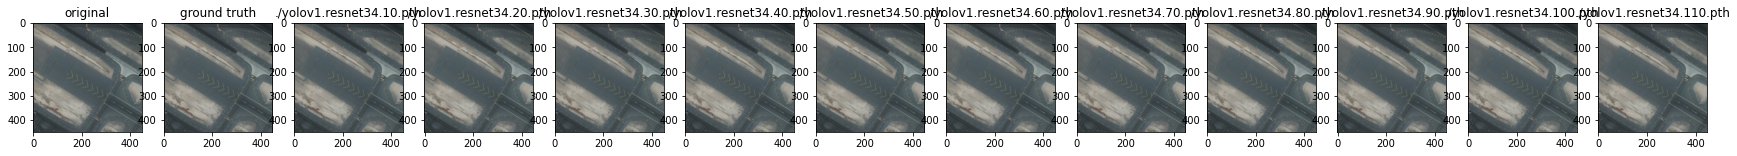

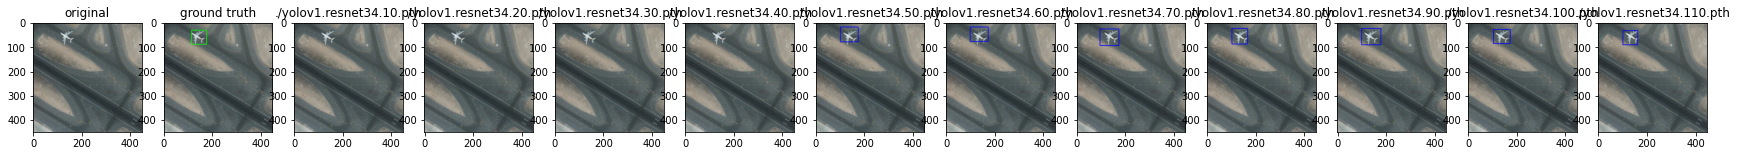

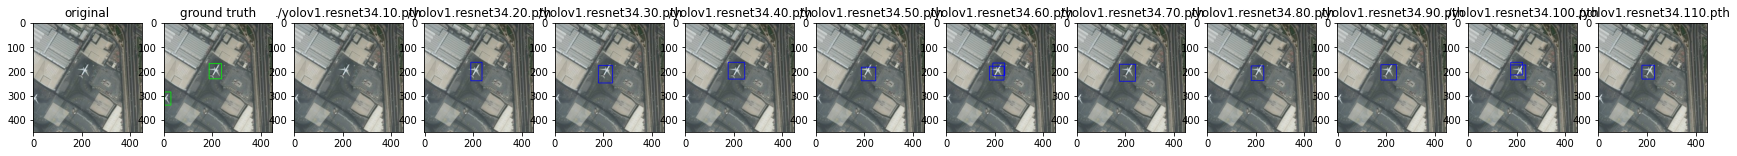

In [61]:
lots_of_prediction_and_lots_of_model(np.random.randint(low=0,high=len(testset),size=5),
                                     [f'./yolov1.{MODEL_BACKBONE}.{(i+1)*10}.pth' for i in range(0,11)])

/home/labuser/miniconda3/lib/python3.9/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755849709/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


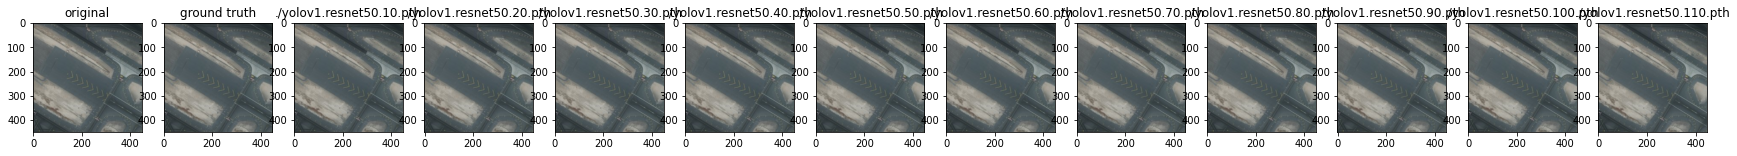

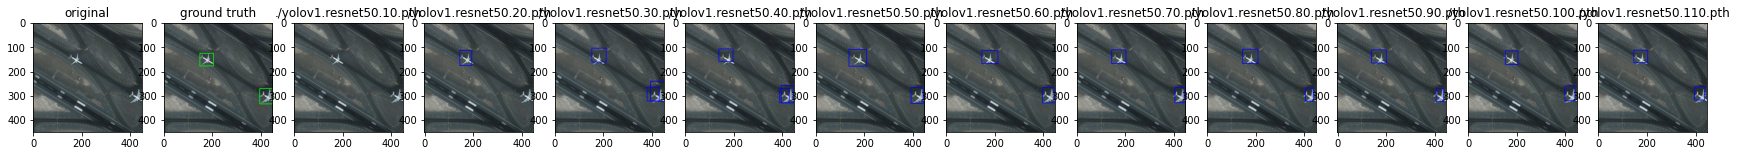

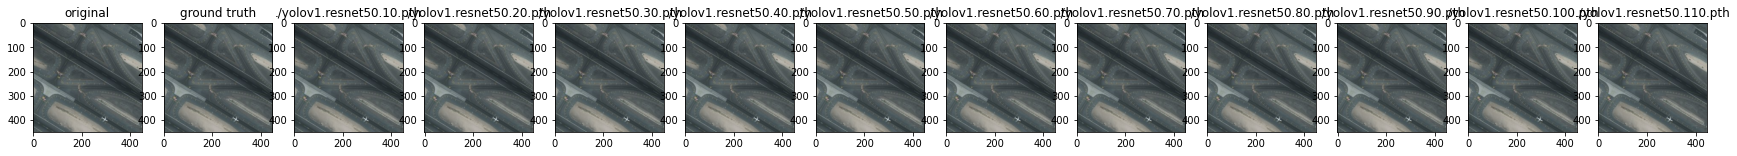

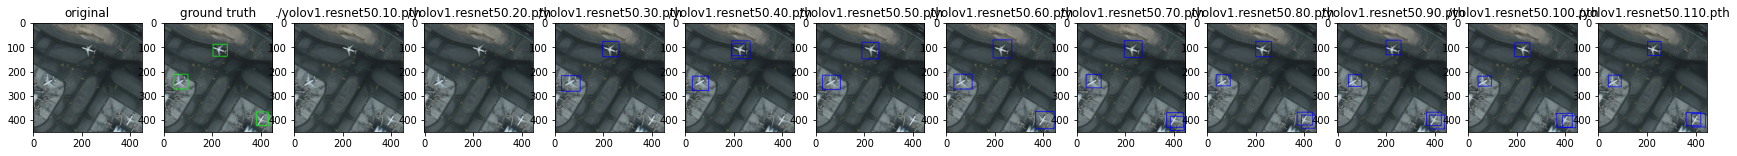

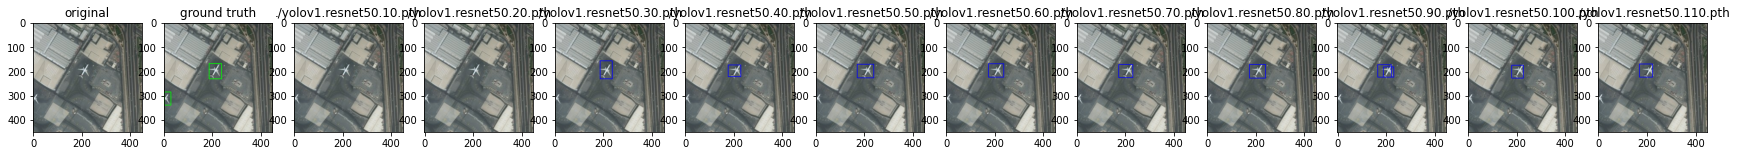

In [40]:
lots_of_prediction_and_lots_of_model(np.random.randint(low=0,high=len(testset),size=5),
                                     [f'./yolov1.{MODEL_BACKBONE}.{(i+1)*10}.pth' for i in range(0,11)])